<a href="https://colab.research.google.com/github/justKishore/API-practice/blob/main/s3971501_s3995645.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import os
import numpy as np
from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to the data directory in your Google Drive
data_dir = "/content/drive/MyDrive/CML/trafficsigns_dataset"

# Step 1: Read Data and Assign Labels
X = []
y_parent = []  # Labels for parent folders
y_subfolder = []  # Labels for subfolders within each parent folder
x_img=[]
name=[]

for parent_folder in os.listdir(data_dir):
    parent_folder_path = os.path.join(data_dir, parent_folder)
    if os.path.isdir(parent_folder_path):
        for subfolder in os.listdir(parent_folder_path):
            subfolder_path = os.path.join(parent_folder_path, subfolder)
            if os.path.isdir(subfolder_path):
                for image_name in os.listdir(subfolder_path):
                    # Ignore certain files like .DS_Store or README
                    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_path = os.path.join(subfolder_path, image_name)
                        name.append(image_name)
                        image = io.imread(image_path)
                        image = transform.resize(image, (100, 100))
                        x_img.append(image)
                        X.append(image.flatten())
                        y_parent.append(parent_folder)
                        y_subfolder.append(subfolder)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
x_img[0], y_parent[0], y_subfolder[0], name[0]

(array([[0.33291294, 0.3301898 , 0.33135686, ..., 0.29003922, 0.29098039,
         0.28878431],
        [0.33568   , 0.33080471, 0.33289412, ..., 0.28894118, 0.28988235,
         0.28768627],
        [0.33449412, 0.33054118, 0.33223529, ..., 0.28941176, 0.29035294,
         0.28815686],
        ...,
        [0.30174118, 0.30130196, 0.3014902 , ..., 0.24047059, 0.23501176,
         0.24774902],
        [0.30187294, 0.30169725, 0.30177255, ..., 0.23830588, 0.23273412,
         0.2457349 ],
        [0.30156549, 0.3007749 , 0.30111373, ..., 0.24335686, 0.23804863,
         0.25043451]]),
 'triangle',
 'giveway',
 '00056_00001.png')

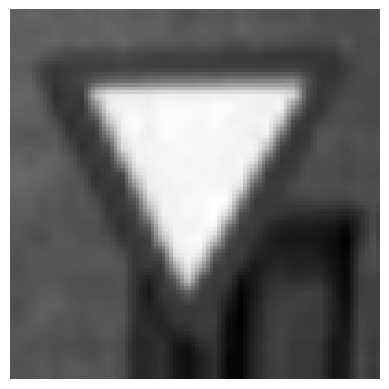

In [18]:
import matplotlib.pyplot as plt

image_shape = (100, 100)
image = x_img[0].reshape(image_shape)

# Display the image
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()
